# $J$-factors Maps

Making bidimensional $J$-factors maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
import astropy.wcs as wcs
from astropy.io import fits

In [3]:
from dm.profiles import MassProfileNFW, MassProfileEinasto, MassProfileIsothermal, MassProfileBurkert, MassProfileMoore

In [4]:
plt.style.use('astroph')

#### Grid generator

In [5]:
def generate_grid(l, b):
    L, B = np.meshgrid(l, b)
    thetas = np.arccos(np.cos(L)*np.cos(B))
    return thetas

#### Plot profiles 

In [6]:
def profile_plot(j_factors, l, b, wcs, cmap=plt.cm.plasma, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(j_factors, origin='lower', cmap=cmap, **kwargs)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$J(\theta)$", labelpad=10)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$b$ ($\degree$)')
    ax.set_xlabel(r'$\ell$ ($\degree$)')
    for x in range(l.size):
        ax.axvline(x, color='grey', lw=0.3, alpha=0.8)
    for y in range(b.size):
        ax.axhline(y, color='grey', lw=0.3, alpha=0.8)

#### WCS Generator

In [7]:
def generate_wcs(l, b):
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ['GLON-CAR', 'GLAT-CAR']
    w.wcs.crval = np.array([l[0], b[0]])
    w.wcs.crpix = np.array([0.5, 0.5])
    w.wcs.cdelt = np.array([l.ptp()/l.size, b.ptp()/b.size], dtype=np.float64)
    w.wcs.cunit = ['deg', 'deg']
    return w

#### FITS Generator

In [8]:
def generate_fits(data, wcs, filename):
    hdu = fits.PrimaryHDU(data, header=wcs.to_header())
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

## Profiles

In [9]:
nfw = MassProfileNFW()
einasto = MassProfileEinasto()
isothermal = MassProfileIsothermal()
burkert = MassProfileBurkert()
moore = MassProfileMoore()

## Regions

### ```GC 1```

| Latitude ($b$) or aperture ($\theta$) | Longitude ($\ell$)|
|:----: |:---:|
| $\theta < 0.1°$| - |


In [10]:
n1 = 60

In [11]:
b_min1, b_max1, l_min1, l_max1 = -0.1, 0.1, -0.1, 0.1

In [12]:
b1 = np.linspace(b_min1, b_max1, n1)
l1 = np.linspace(l_min1, l_max1, n1)

In [13]:
theta1 = generate_grid(l1, b1)*np.pi/180.0

In [14]:
nfw_map1 = nfw.j_factor_map(theta1, epsrel=1e-3)

In [15]:
einasto_map1 = einasto.j_factor_map(theta1, epsrel=1e-3) 

In [16]:
isothermal_map1 = isothermal.j_factor_map(theta1, epsrel=1e-3)

In [17]:
burkert_map1 = burkert.j_factor_map(theta1, epsrel=1e-3)

In [18]:
moore_map1 = moore.j_factor_map(theta1, epsrel=1e-3)

#### Maps

In [19]:
w = wcs.WCS(naxis=2)

In [20]:
wcs1 = generate_wcs(l1, b1)

* NFW

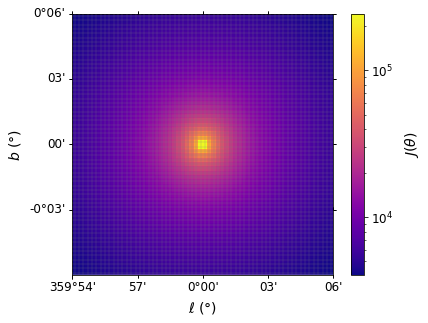

In [21]:
profile_plot(nfw_map1, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_map1.min(), vmax=nfw_map1.max()))

In [22]:
generate_fits(nfw_map1, wcs1, 'maps/nfw_gc1.fits')

* Einasto

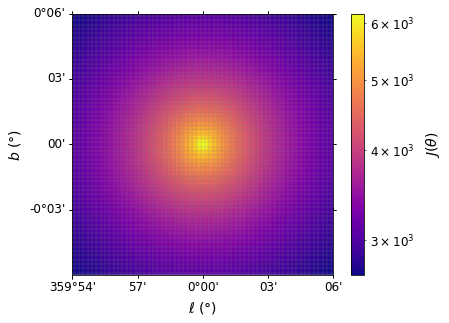

In [23]:
profile_plot(einasto_map1, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=einasto_map1.min(), vmax=einasto_map1.max()))

In [24]:
generate_fits(einasto_map1, wcs1, 'maps/einasto_gc1.fits')

* Isothermal

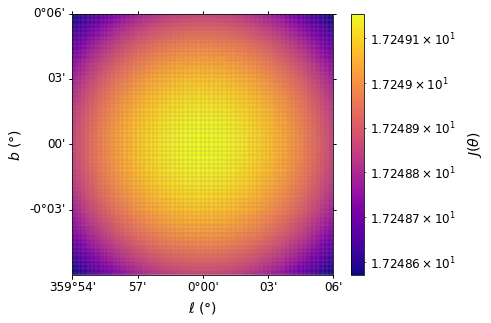

In [25]:
profile_plot(isothermal_map1, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=isothermal_map1.min(), vmax=isothermal_map1.max()))

In [26]:
generate_fits(isothermal_map1, wcs1, 'maps/isothermal_gc1.fits')

* Burkert 

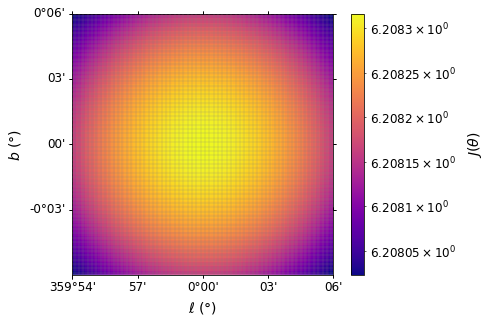

In [27]:
profile_plot(burkert_map1, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=burkert_map1.min(), vmax=burkert_map1.max()))

In [28]:
generate_fits(burkert_map1, wcs1, 'maps/burkert_gc1.fits')

* Moore

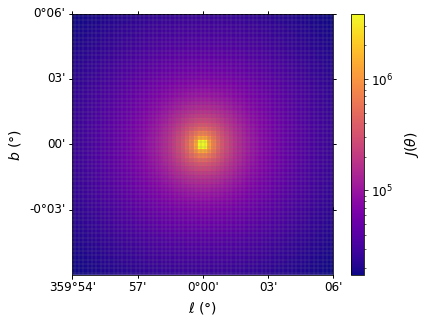

In [29]:
profile_plot(moore_map1, l1, b1, wcs1, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=moore_map1.min(), vmax=moore_map1.max()))

In [30]:
generate_fits(moore_map1, wcs1, 'maps/moore_gc1.fits')

### ```GC 2```

| Latitude ($b$) or aperture ($\theta$) | Longitude ($\ell$)|
|:----: |:---:|
| $\theta < 0.14°$| - |


In [31]:
n2 = 60

In [32]:
b_min2, b_max2, l_min2, l_max2 = -0.14, 0.14, -0.14, 0.14

In [33]:
b2 = np.linspace(b_min2, b_max2, n2)
l2 = np.linspace(l_min2, l_max2, n2)

In [34]:
theta2 = generate_grid(l2, b2)*np.pi/180.0

In [35]:
nfw_map2 = nfw.j_factor_map(theta2, epsrel=1e-3)

In [36]:
einasto_map2 = einasto.j_factor_map(theta2, epsrel=1e-3) 

In [37]:
isothermal_map2 = isothermal.j_factor_map(theta2, epsrel=1e-3)

In [38]:
burkert_map2 = burkert.j_factor_map(theta2, epsrel=1e-3)

In [39]:
moore_map2 = moore.j_factor_map(theta2, epsrel=1e-3)

#### Maps

In [40]:
wcs2 = generate_wcs(l2, b2)

* NFW

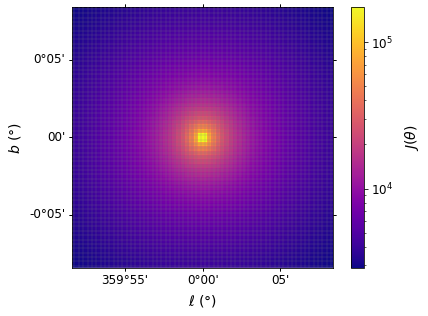

In [41]:
profile_plot(nfw_map2, l2, b2, wcs2, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_map2.min(), vmax=nfw_map2.max()))

In [42]:
generate_fits(nfw_map2, wcs2, 'maps/nfw_gc2.fits')

* Einasto

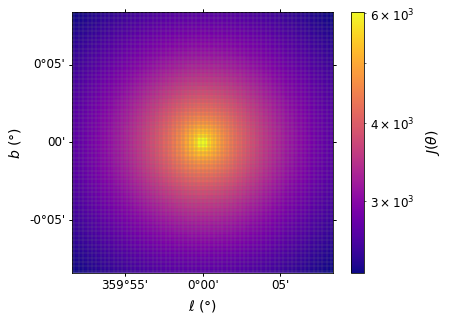

In [43]:
profile_plot(einasto_map2, b2, l2, wcs2, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=einasto_map2.min(), vmax=einasto_map2.max()))

In [44]:
generate_fits(einasto_map2, wcs2, 'maps/einasto_gc2.fits')

* Isothermal

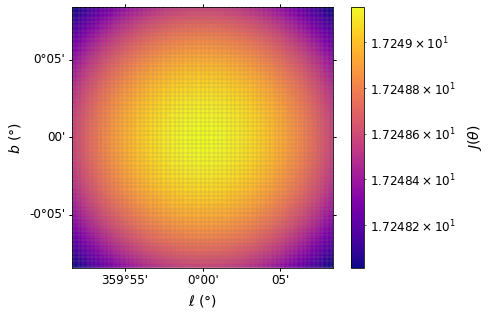

In [45]:
profile_plot(isothermal_map2, b2, l2, wcs2, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=isothermal_map2.min(), vmax=isothermal_map2.max()))

In [46]:
generate_fits(isothermal_map2, wcs2, 'maps/isothermal_gc2.fits')

* Burkert 

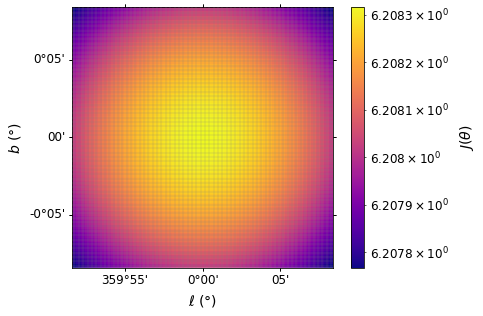

In [47]:
profile_plot(burkert_map2, b2, l2, wcs2, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=burkert_map2.min(), vmax=burkert_map2.max()))

In [48]:
generate_fits(burkert_map2, wcs2, 'maps/burkert_gc2.fits')

* Moore

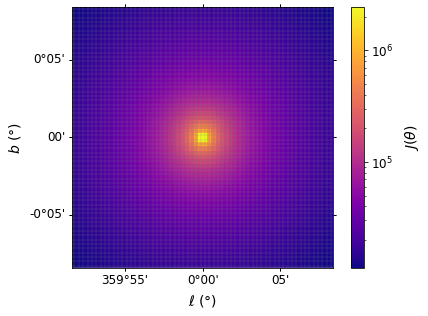

In [49]:
profile_plot(moore_map2, b2, l2, wcs2, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=moore_map2.min(), vmax=moore_map2.max()))

In [50]:
generate_fits(moore_map2, wcs2, 'maps/moore_gc2.fits')

### ```GC 3```

| Latitude ($b$) or aperture ($\theta$) | Longitude ($\ell$) |
|:----: |:---:|
| $\theta < 1°$| - |


In [51]:
n3 = 60

In [52]:
b_min3, b_max3, l_min3, l_max3 = -1.0, 1.0, -1.0, 1.0

In [53]:
b3 = np.linspace(b_min3, b_max3, n3)
l3 = np.linspace(l_min3, l_max3, n3)

In [54]:
theta3 = generate_grid(b3, l3)*np.pi/180.0

In [55]:
nfw_map3 = nfw.j_factor_map(theta3, epsrel=1e-3)

In [56]:
einasto_map3 = einasto.j_factor_map(theta3, epsrel=1e-3) 

In [57]:
isothermal_map3 = isothermal.j_factor_map(theta3, epsrel=1e-3)

In [58]:
burkert_map3 = burkert.j_factor_map(theta3, epsrel=1e-3)

In [59]:
moore_map3 = moore.j_factor_map(theta3, epsrel=1e-3)

#### Maps

In [60]:
wcs3 = generate_wcs(l3, b3)

* NFW

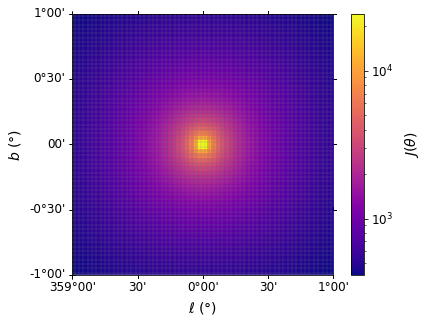

In [61]:
profile_plot(nfw_map3, b3, l3, wcs3, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=nfw_map3.min(), vmax=nfw_map3.max()))

In [62]:
generate_fits(nfw_map3, wcs3, 'maps/nfw_gc3.fits')

* Einasto

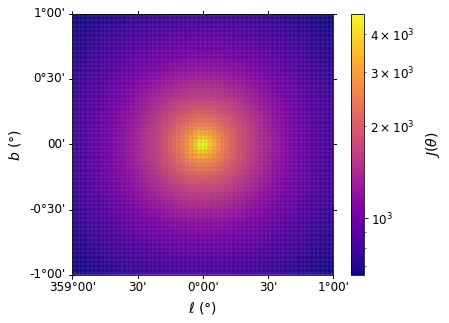

In [63]:
profile_plot(einasto_map3, b3, l3, wcs3, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=einasto_map3.min(), vmax=einasto_map3.max()))

In [64]:
generate_fits(einasto_map3, wcs3, 'maps/einasto_gc3.fits')

* Isothermal

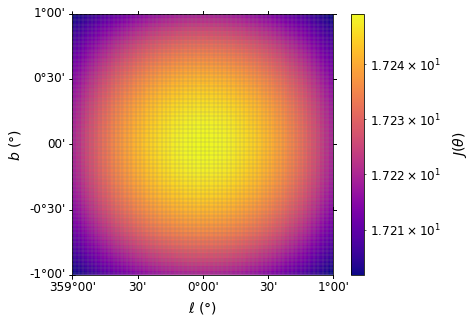

In [65]:
profile_plot(isothermal_map3, b3, l3, wcs3, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=isothermal_map3.min(), vmax=isothermal_map3.max()))

In [66]:
generate_fits(isothermal_map3, wcs3, 'maps/isothermal_gc3.fits')

* Burkert 

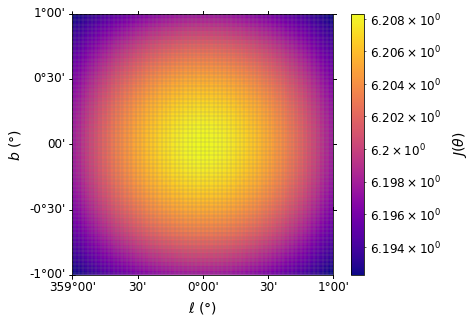

In [67]:
profile_plot(burkert_map3, b3, l3, wcs3, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=burkert_map3.min(), vmax=burkert_map3.max()))

In [68]:
generate_fits(burkert_map3, wcs3, 'maps/burkert_gc3.fits')

* Moore

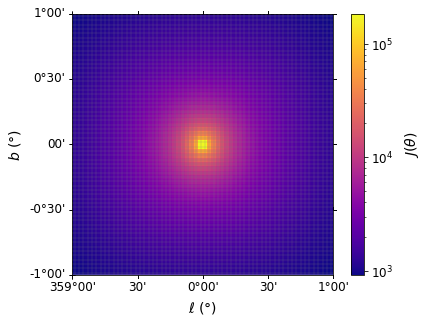

In [69]:
profile_plot(moore_map3, b3, l3, wcs3, cmap=plt.cm.plasma, norm=colors.LogNorm(vmin=moore_map3.min(), vmax=moore_map3.max()))

In [70]:
generate_fits(moore_map3, wcs3, 'maps/moore_gc3.fits')